In [3]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.4MB/s 


In [4]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import emcee
import seaborn as sns
import corner
import pymc3 as pm

In [5]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


In [6]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [7]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
yerr=0.05

In [8]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


"""
Función de Maxima Probabilidad

"""




#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 

"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta


  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
  #if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
  #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
  #if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
  #if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      return 0.0
  return -np.inf



# log probabilidad

"""posterior """
def log_probability(theta, x, y, yerr):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 

#Método de las discrepancias

una vez tenemos desarrollado el modelo estadístico, el siguiente paso es determinar su validación, la cual nos dirá si este modelo logra representar lo datos tomados por la antena, con una buena aproximación los datos tomados por el proyecto de Edges, o el si las incertidumbres en las medidas son tan grandes,.------- 
EL método de las discrepancias, consiste en calcular la diferencias entre un conjunto de valores sintéticos generados usando el modelo, y los valores reales tomados del radiotelescopio de Edges


In [9]:
"""Funcion de discrepancia"""

# Recibe como parametros, las datos las muestras(samples), las frecuancias(x), y las temperaturas de sky(y)##

def Discrepancia(samples,x,y):
    """
    discs=[]
      disco=[]
      rej=0
    """
    n_100=len(samples)//100 # we only take 1 discrepancy sample for every 100 random walker sampled set of parameter points
    for i in range(n_100):
        yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
        yexp=np.sqrt(yexp) # expected values yexp for H/M errors from the linear model  
                           # from a random parameter space point (m,c,b,f) taken from the posterior samples
        modpar=samples[np.random.randint(len(samples))] # take another random parameter space point (m,b,f) 
                                                        # from the posterior samples
        # use modpar to generate a synthetic ysim for each x using the likelihood
        ymod=(modpar[0]*x+modpar[3])**2+modpar[1]**2
        ymod=np.sqrt(ymod)
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # simulated discrepancy (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # observed discrepancy (Freeman-Tukey)
    print("Rejection rate =",100*rej//ndisc,"%") # fraction of times a negative ysim was generated wrt the number of discrepancy samples
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        # make the discrepancy plot
        plt.scatter(disco,discs,alpha=0.4,label=r"$N_\mathrm{TF}>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
        # the Bayesian "p-value" is the fraction of discrepancy realizations 
        # when the observed discrepancy is lower than the simulated discrepancy
        # ideally this "p-value" should not be close to 0 or 1
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

##Conjunto de constantes

In [10]:
#Bow=1570.0/1000, 700.0/1000,-1100.0/1000,750.0/1000,-175.0/1000,0.567,78.3,20.75,800.0,0.05

Bow= 1570, 700,-1100,750,-175,0.530,78.3,20.75,8.0,0.05             # intersección con el eje y
Pyemcee= -11221.09499241, -14168.57143649, -10203.98895781,    144.62969775,12659.42909717,500.0/1000,78.3,19.0,7.0,0.05   #ajuste coeficientes de minimos cuadrados
Pyemcee2=  1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908, 0.524285560037914, 78.6235695471557, 21.162879332114997,7.6124372729808196,0.05
Intento= -14285.22801433, -17568.34439754, -12412.45765732,    167.33842652, 15700.28024181, 0.51948421412718, 78.51820480335225, 19.32741526388625, 7.001176416303,0.05
Natu_result= -10111.419 ,-5673.739 ,-1831.621 ,150.673 ,11711.500 ,0.553, 6.78 ,78.31 ,18.74,0.05
Natu= 2000, -720,1000,-720,175,1.12,78.3,19.5,2.8,0.05 
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

In [11]:
def disc(ii,samples,x,y):
  #arreglos vacios para guardad los valores de la discrepancia simulada y observada 
  discs=[] 
  disco=[] 
  rej=0 ## Tasa de rechazo
  samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  #yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
  #yexp=np.sqrt(yexp)
  samples[:,0]
  n_100=len(samples)//1 # Candtidad de elementos a selecionar del nwalkers
  for i in range(n_100):
    # yexp es una arreglo que contiene  
    #yexp=T_sky(x,samples[i,0],samples[i,1],samples[i,2],samples[i,3],samples[i,4],samples[i,5],samples[i,6],samples[i,7],samples[i,8] )
    yexp=T_sky(x,*samples[i])
    modpar=samples[np.random.randint(len(samples))] # Elige un conjunto de parametos de forma aleatoria de la muestra
    # Con los parametros del modelo, generamos datos sintéticos
    ymod=T_sky(x,*modpar) # Tsky modelo
    #ymod=np.sqrt(ymod)
    ysim=np.random.normal(ymod,0.05) #Generando datos sinteticos
    if np.any(yexp<0)|np.any(ysim<0):
        rej+=1 # this checks if a negative ysim is generated
    else:        
        discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
        disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
  print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
  if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
      # make the discrepancy plot
      plt.scatter(disco,discs,alpha=0.4,label=str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

#Ejemplo del metodo de las discerepancias. 
usando los datos de bowman y pyemcee

100%|██████████| 10000/10000 [03:55<00:00, 42.52it/s]


Rejection rate = 0 %
Bayesian p-value: 0.6103555555555555


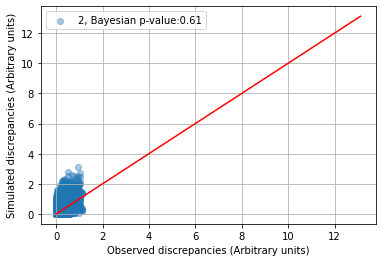

In [12]:
#for ii in range(len(Cons)):

ii=2  
params=  Cons[ii]
Sol=params[0:9]
N=len(Sol)
Walkers=2500
steps=10000
pos = Sol+ 10e-1 * np.random.randn(Walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, steps, progress=True);
samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
disc(ii,samples,x,y)
plt.legend(loc='upper left',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.grid()
#plt.xlim(-0.5,50)
#plt.ylim(0,20)

In [13]:
  ii=0
  params=  Cons[ii]
  Sol=params[0:9]
  N=len(Sol)
  Walkers=2500
  steps=10000
  pos = Sol+ 10e-1 * np.random.randn(Walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);


100%|██████████| 10000/10000 [04:24<00:00, 37.77it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


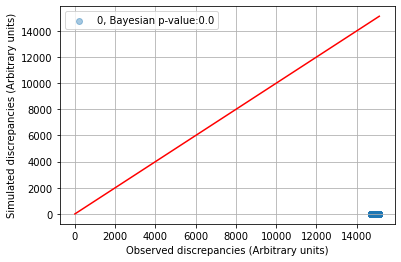

In [14]:
  samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  disc(ii,samples,x,y)
  plt.legend(loc='upper left',frameon=True)
  plt.xlabel('Observed discrepancies (Arbitrary units)')
  plt.ylabel('Simulated discrepancies (Arbitrary units)')
  plt.grid()

###las siguientes funciones incluyen sigma como un parámetro a calcular

In [16]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f_s(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21_s(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky_s(v,a0,a1,a2,a3,a4,A,v0,w,tau,sigma):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf


"""
Función de Maxima Probabilidad

"""




#### Funcion de probabilidad

def log_likelihood_s(theta,x,y,yerr):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 

"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p_s (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma = theta


  #if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 370.0 < A < 670.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
  if 1400 < a0 < 1650 and 400 < a1 < 900 and  -1600< a2 <-600 and 450 <a3 < 950 and -225 < a4 < -100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
  #if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):
  #if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -600.0 and  800.0< a2 <1060.0 and -800.0 <a3 < -620.0 and 150.0 < a4 < 210.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 :  #O Artículo
  #if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      return 0.0
  return -np.inf



# log probabilidad

"""posterior """
def log_probability_s(theta, x, y, yerr):
    lp = log_p_s(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_s(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 

In [17]:
def disc_s(ii,samples,x,y):
  #arreglos vacios para guardad los valores de la discrepancia simulada y observada 
  discs=[] 
  disco=[] 
  rej=0 ## Tasa de rechazo
  samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  #yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
  #yexp=np.sqrt(yexp)
  samples[:,0]
  n_100=len(samples)//100 # Candtidad de elementos a selecionar del nwalkers
  for i in range(n_100):
    # yexp es una arreglo que contiene  
    #yexp=T_sky(x,samples[i,0],samples[i,1],samples[i,2],samples[i,3],samples[i,4],samples[i,5],samples[i,6],samples[i,7],samples[i,8] )
    yexp=T_sky_s(x,*samples[i])
    modpar=samples[np.random.randint(len(samples))] # Elige un conjunto de parametos de forma aleatoria de la muestra
    # Con los parametros del modelo, generamos datos sintéticos
    ymod=T_sky_s(x,*modpar) # Tsky modelo
    #ymod=np.sqrt(ymod)
    ysim=np.random.normal(ymod,abs(modpar[9])) #Generando datos sinteticos
    if np.any(yexp<0)|np.any(ysim<0):
        rej+=1 # this checks if a negative ysim is generated
    else:        
        discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
        disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
  print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
  if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
      # make the discrepancy plot
      plt.figure()
      plt.scatter(disco,discs,alpha=0.4,label=str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

100%|██████████| 10000/10000 [14:51<00:00, 11.22it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


100%|██████████| 10000/10000 [02:26<00:00, 68.25it/s]


Rejection rate = 0 %
Bayesian p-value: 0.7407407407407407


100%|██████████| 10000/10000 [02:32<00:00, 65.58it/s]


Rejection rate = 0 %
Bayesian p-value: 0.725925925925926


100%|██████████| 10000/10000 [02:28<00:00, 67.47it/s]


Rejection rate = 0 %
Bayesian p-value: 0.7777777777777778


100%|██████████| 10000/10000 [02:29<00:00, 67.03it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


100%|██████████| 10000/10000 [02:32<00:00, 65.46it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


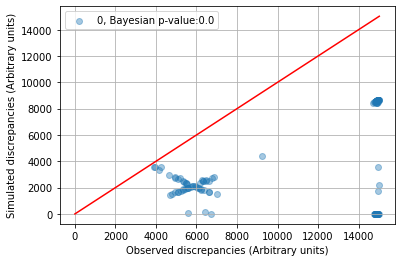

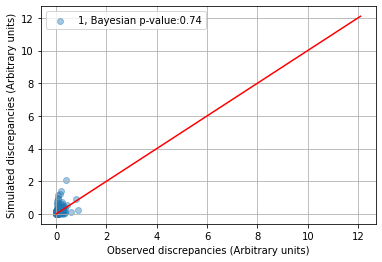

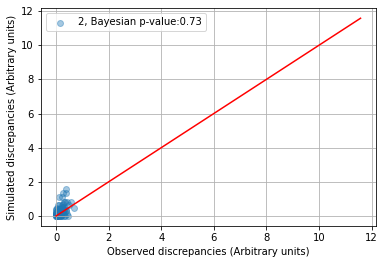

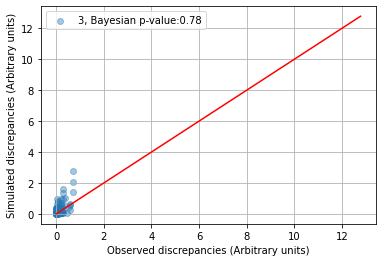

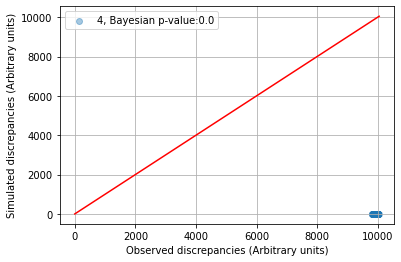

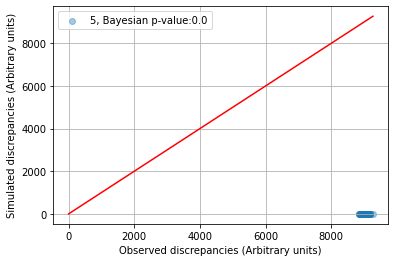

In [18]:
for ii in range(len(Cons)):
  
  
  Sol=  Cons[ii]
  
  N=len(Sol)
  Walkers=1500
  steps=10000
  pos = Sol+ 10e-1 * np.random.randn(Walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_s, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  disc_s(ii,samples,x,y)
  plt.legend(loc='upper left',frameon=True)
  plt.xlabel('Observed discrepancies (Arbitrary units)')
  plt.ylabel('Simulated discrepancies (Arbitrary units)')
  plt.grid()

In [ ]:
abs(modpar[9])

1.0738888381123908

##Correlación

100%|██████████| 10000/10000 [13:11<00:00, 12.64it/s]


2.9991019815497038 0.0013742959406530966
2.9987416432077603 0.0016243360111682984
2.9990591280108787 0.0014095873103603116
2.9994183527102236 0.0012174549047825336
2.998466242857944 0.0018660170818792141
2.9961659758531303 0.006019625051896455
2.9962112193445387 0.0034216513296562974
2.996943244554585 0.0031640855581907008
2.99300560087207 0.007337721040573082
2.9861770680891544 0.03527325392382933


100%|██████████| 10000/10000 [02:35<00:00, 64.44it/s]


2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998 0.0


100%|██████████| 10000/10000 [02:37<00:00, 63.44it/s]


2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998 0.0


100%|██████████| 10000/10000 [02:34<00:00, 64.58it/s]


2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9997999999999996 4.440892098500626e-16
2.9998 0.0


100%|██████████| 10000/10000 [02:36<00:00, 63.74it/s]


2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0


100%|██████████| 10000/10000 [02:33<00:00, 65.02it/s]


2.9998 0.0
2.9997999999999996 4.440892098500626e-16
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9998000000000005 4.440892098500626e-16
2.9998 0.0
2.9998 0.0
2.9998 0.0


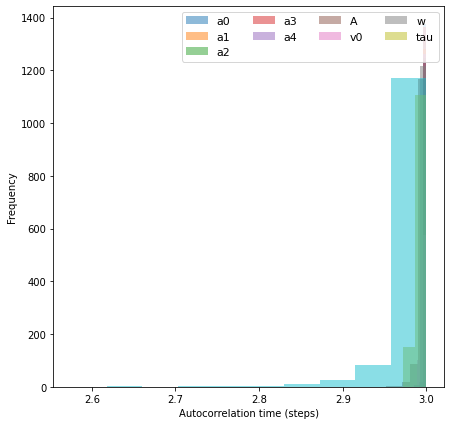

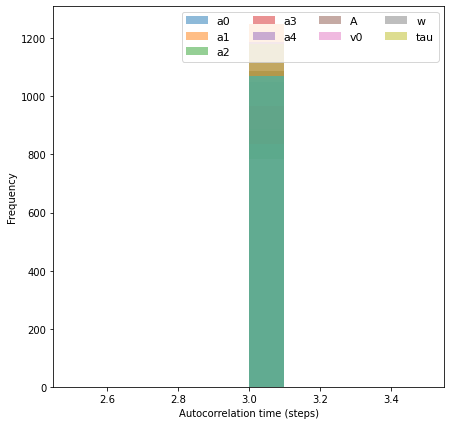

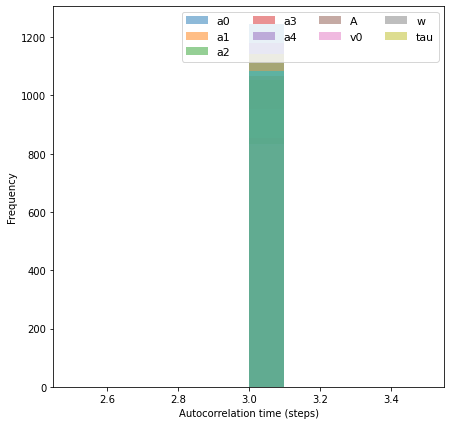

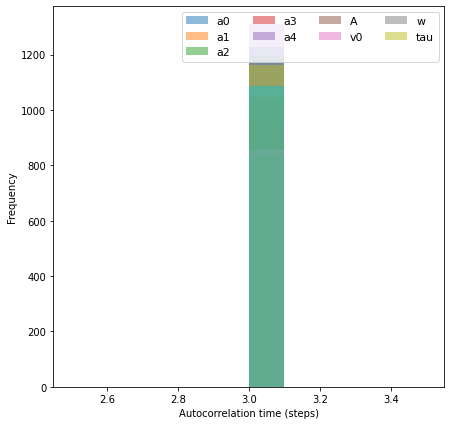

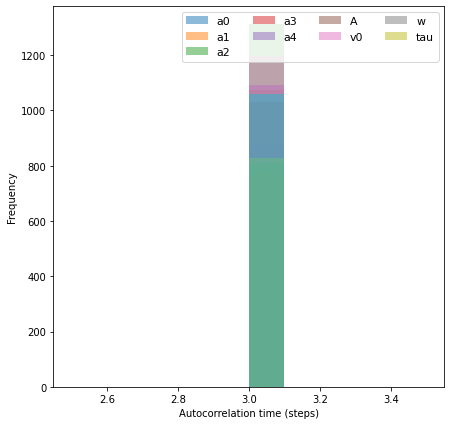

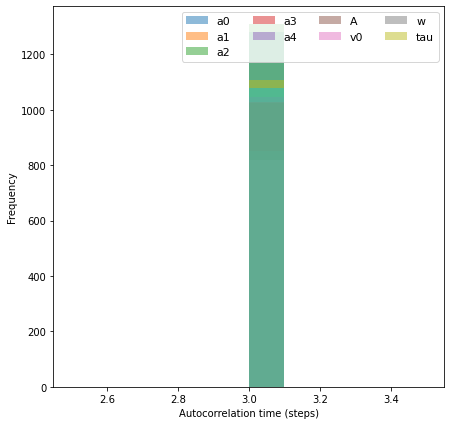

In [ ]:

for k in range(len(Cons)):
  plt.figure(figsize=(7,7))  
  Sol=  Cons[k]

  N=len(Sol)
  Walkers=1500
  steps=10000
  pos = Sol+ 10e-1 * np.random.randn(Walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_s, args=(x, y, yerr))
  sampler.run_mcmc(pos, steps, progress=True);
  names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
  for j in range(N): # Range NConstans
      autocorr=[]
      for i in range(1500): # Range NWalker 
          autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=0.05))
      autocorr = [x for x in autocorr if pd.isnull(x) == False]    
      autocorr=np.asarray(autocorr)
      plt.hist(autocorr,alpha=0.5)

      print(autocorr.mean(),autocorr.std())
  plt.xlabel("Autocorrelation time (steps)")
  plt.ylabel("Frequency")
  plt.legend(
            names,
            scatterpoints=1,
            loc='upper right',
            ncol=4,
            fontsize=11)

122.14099930171058 61.791577616815246


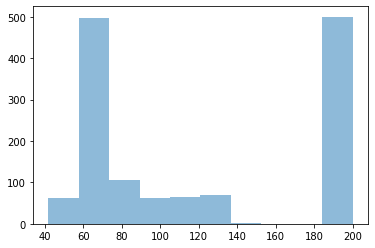

In [ ]:
autocorr=[]
for i in range(1500):
  autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=0.5))
autocorr = [x for x in autocorr if pd.isnull(x) == False]
autocorr=np.array(autocorr)
#autocorr[np.isnan(autocorr)] = 0

plt.hist(autocorr,alpha=0.5)
print(autocorr.mean(),autocorr.std())

In [ ]:
#np.isnan(autocorr)=0
autocorr = [x for x in autocorr if pd.isnull(x) == False]

np.shape(autocorr)

(1076, 1)

In [ ]:
np.round(theta,3)

array([-1.1221095e+04, -1.4168571e+04, -1.0203989e+04,  1.4463000e+02,
        1.2659429e+04,  5.0000000e-01,  7.8300000e+01,  1.9000000e+01,
        7.0000000e+00])

##( Avance 16/04/2020) 
Se definió el nuevo conjunto de intervalos de la función prior, en las cuales se toman intervalos extendidos para los conjuntos dentro de la función prior

In [19]:
def nwlakers1(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-1 * np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability1, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params
def log_probability1(theta, x, y, yerr,i):
    lp = log_p1(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_s(theta, x, y, yerr)
def log_p1 (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma = theta
  a0=np.round(a0,3)

  if Cons_names[i]== 'Bow':
    if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0 and 0.04 <sigma< 0.06:
    #if 1.400 < a0 < 1.650 and 0.400 < a1 < 0.900 and  -0.1600< a2 <-0.600 and 0.450 <a3 < 0.950 and -0.225 < a4 < -0.100 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6: 
      return 0.0
  if Cons_names[i]=='Pyemcee':
    if -20000.0 < a0 < 20000.0 and -20000.0 < a1 < 20000.0 and  -20000.0< a2 <20000.0 and -20000.0 <a3 < 20000.0 and -20000.0 < a4 < 20000.0 and 0.09 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.5 <tau< 14.8 :
      return 0.0
  if Cons_names[i]=='Pyemcee2':
    if 1400 < a0 < 1650 and 400 < a1 < 900 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370< A < 0.670 and 77.4  < v0 < 78.5 and 17.0  < w < 22.8 and 6.0<tau<7.8 and 0.0 <sigma< 0.6:
      return 0.0
  if Cons_names[i]=='Natu_result':
    if -2000 < a0 < 2000.0 and -2000.0 < a1 < 2000.0 and  -2000.0< a2 <2000.0 and -2000.0 <a3 < 2000.0 and -2000 < a4 < 2000.0 and 0.90 < A < 1.30 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 2.5 <tau< 4.8 : #intervalos expandidos  
      print('ok')
      return 0.0
  if Cons_names[i]=='Intento':
    if -20000 < a0 < 20000.0 and -20000.0 < a1 < 20000.0 and  -20000.0< a2 <20000.0 and -20000.0 <a3 < 20000.0 and -20000 < a4 < 20000.0 and 0.0 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.5 <tau< 14.8 : #intervalos expandidos  
        print('ok')
        return 0.0
  if  Cons_names[i]=='Natu':
    if 1980.0 < a0 < 2030.0 and -800.0 < a1 < -200.0 and  -200.0< a2 <1060.0 and -800.0 <a3 < 1800.0 and 150.0 < a4 < 210.0 and 0.0 < A < 1.30 and  77.8< v0 <78.8 and 17.5 <w < 22.0 and 2.0 <tau< 14.8 :  #O Artículo
      return 0.0
  return -np.inf   
#if (a0-1000.0) < a0 < (a0+1000.0) and (a1-400.0) < a1 < (a1+400.0) and  (a2-100.0)< a2 <(a2 +100.0) and (a3-450.0) <a3 < (a3+450.0) and (a4 -500.0) < a4 < (a4 +500.0) and (A-0.5) < A <(A+ 0.67) and (v0-2.4)  < v0 <(v0 + 2.5) and (w-20.0)  < w <(w+ 22.8 )and (tau-6.0)<tau<(tau+7.8):

100%|██████████| 10000/10000 [12:19<00:00, 13.53it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


100%|██████████| 10000/10000 [48:01<00:00,  3.47it/s]


Rejection rate = 0 %
Bayesian p-value: 0.8740740740740741


100%|██████████| 10000/10000 [05:47<00:00, 28.74it/s]


Rejection rate = 0 %
Bayesian p-value: 0.7185185185185186


100%|██████████| 10000/10000 [05:46<00:00, 28.83it/s]


Rejection rate = 0 %
Bayesian p-value: 0.7111111111111111


100%|██████████| 10000/10000 [06:15<00:00, 26.63it/s]


Rejection rate = 0 %
Bayesian p-value: 0.0


100%|██████████| 10000/10000 [35:46<00:00,  4.66it/s]


Rejection rate = 0 %
Bayesian p-value: 0.4074074074074074


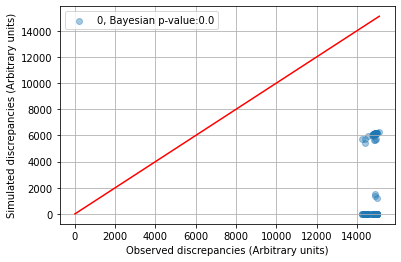

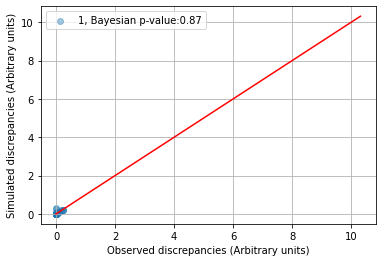

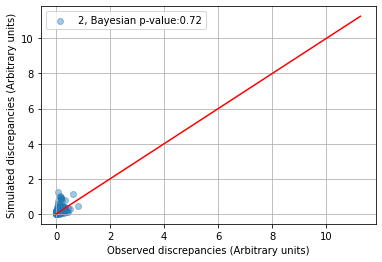

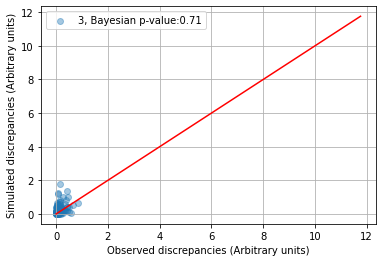

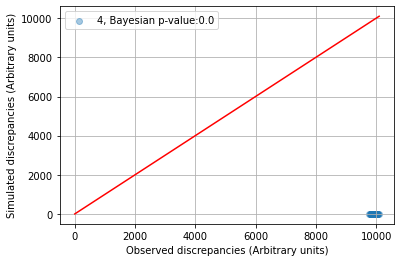

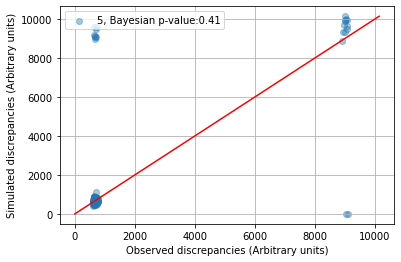

In [20]:
for ii in range(len(Cons)):
  
  
  Sol=  Cons[ii]
  
  N=len(Sol)
  Walkers=1500
  steps=10000
  pos = Sol+ 10e-1 * np.random.randn(Walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability1, args=(x, y, yerr,ii))
  sampler.run_mcmc(pos, steps, progress=True);
  samples=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros
  disc_s(ii,samples,x,y)
  plt.legend(loc='upper left',frameon=True)
  plt.xlabel('Observed discrepancies (Arbitrary units)')
  plt.ylabel('Simulated discrepancies (Arbitrary units)')
  plt.grid()